<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import sys
sys.path.append('../')
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from src.pipeline_helpers import get_proportions
from transformers import BertTokenizer
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, GlobalMaxPool1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tqdm.auto import tqdm
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizer
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [7]:
PROJECT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = PROJECT_PATH + '/data/'
MODEL_PATH = PROJECT_PATH + '/models/'

In [8]:
df = pd.read_csv(DATA_PATH + 'preprocessed.csv')

In [6]:
df.sample(10)

,complaint_description,assigned_division
60430,Kitchen sink is backing up for over a year. c...,Plumbing Inspection Division
8949,Lack of hot water.....entire building. --- cus...,Housing Inspection Services
140828,Install new windows and sidings without a permit,Building Inspection Division
111916,Exceeding scope of work under pa #200812088049...,Building Inspection Division
145504,Electrical work performed w/o permit. exposed...,Electrical Inspection Division
92371,Paint peeling. possible lead hazard. carpet is...,Housing Inspection Services
99306,Clogged kitchen sink. water from faucet has wh...,Plumbing Inspection Division
32244,3108 jackson - construction of single family r...,Building Inspection Division
42063,Construction during sip.,Building Inspection Division
47354,Light fixture in the hallway is burned out. l...,Housing Inspection Services


In [7]:
df.isna().sum()

complaint_description    0
assigned_division        0
dtype: int64

In [8]:
X = df.complaint_description
y = df.assigned_division

In [9]:
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state = 42, stratify = y_test)

In [11]:
y_train_proportions = get_proportions(y_train)
print(f"y_train proportions: \n {y_train_proportions}\n")

y_train proportions: 
 {0: 0.36652446350078777, 1: 0.006417127687891628, 2: 0.031905786206053104, 3: 0.5013920562865549, 4: 0.09378934267605735}



In [12]:
X_train

6823      Plumbing work redone without permit in unit 30...
157391    Needs to renew boiler permit for permit no 733...
98251     1)lack of security,vagrants in the building.2)...
48283     Landlord is renting basement room with no plum...
160352               Suspects illegal unit and overcrowding
                                ...                        
96943                          15 units, routine inspection
2491      83 pope --- owner is building another shed in ...
132041    A new interior stairway installed without perm...
160221              No proper containment sanding building.
112806                    Installed windows without permit.
Name: complaint_description, Length: 139003, dtype: object

In [13]:
y_train

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0]])

In [14]:
encoder.classes_

array(['Building Inspection Division', 'Disabled Access Division',
       'Electrical Inspection Division', 'Housing Inspection Services',
       'Plumbing Inspection Division'], dtype='<U30')

In [15]:
MAX_LENGTH = 128
def tokenize(sentences, tokenizer):
    """
    Args:
        sentences: The sentences to tokenize.
        tokenizer: The Hugging Face tokenizer object to use.
    
    Returns:
        input_ids: The token id's from DistilBERT.
        input_masks: Which tokens to mask (ignore). 
    """
    input_ids, input_masks = [],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, 
                                       max_length=MAX_LENGTH,truncation=True,padding='max_length',
                                       return_attention_mask=True,return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])      

    return (tf.convert_to_tensor(input_ids), tf.convert_to_tensor(input_masks))

In [16]:
#load DistilBERT tokenizer from pretrainted Hugging Face tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_input_ids, X_train_input_masks = tokenize(X_train,distilbert_tokenizer)
X_val_input_ids, X_val_input_masks = tokenize(X_val,distilbert_tokenizer)
X_test_input_ids, X_test_input_masks = tokenize(X_test,distilbert_tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/139003 [00:00<?, ?it/s]

  0%|          | 0/17376 [00:00<?, ?it/s]

  0%|          | 0/17375 [00:00<?, ?it/s]

In [17]:
DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
#bare pre-trained DistilBERT model outputting raw hidden-states 
#needs head for classification
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilbert.layers:
    layer.trainable = False

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
LEARNING_RATE = 1e-3
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64
NUM_STEPS = X_train_input_ids.shape[0] // BATCH_SIZE

def build_model(transformer, num_classes, max_length=MAX_LENGTH):
    
    """""""""
    Builds a BERT model for classification tasks using a Hugging Face 
    transformer with no head attached.
    
    Input:
      - transformer:  base Hugging Face transformer with no head.
      - max_length:   Controls the maximum number of encoded tokens in 
                      a sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added multi-class 
                      classification layerson top of the base Hugging Face 
                      transformer. 
    """""""""""
    
    #define metrics to monitor
    metrics = [
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.AUC(name='auc'),
    ]

    # define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_masks_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    

    # tf.tensor representing the hidden-state of the model's last layer
    embedding_layer = transformer([input_ids_layer, input_masks_layer])[0]
    X = Bidirectional(LSTM(MAX_LENGTH, return_sequences=True, dropout=0.2))(embedding_layer)
    X = GlobalMaxPool1D()(X)
    X = Dense(MAX_LENGTH, activation='relu')(X)
    X = Dropout(0.2)(X)
    # Define a single node that makes up the output layer (for binary classification)
    output = Dense(num_classes, 
                                   activation='softmax',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(X)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_masks_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy',
                  metrics=metrics)
    
    return model

In [19]:
model = build_model(transformer=distilbert,num_classes=y_train.shape[1])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 128, 768),                                                   
                                 hidden_states=((No                                           

In [21]:
#now we will define a step decay function to reduce our learning rate
def step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=0.75, step_size=10):
    """
    Wrapper function to create a LearningRateScheduler with a set step decay schedule
    """
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

In [22]:
#define callbacks for our model
checkpoint = ModelCheckpoint(filepath = MODEL_PATH + f'BERT/model_{dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}_best_weights.h5', 
                             monitor='val_loss',
                             verbose=1,
                             save_weights_only = True, 
                             save_best_only=True,
                             mode='min')

#learning rate scheduler to decay the learning rate throughout training
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=0.75, step_size=2)

#implement early stopping if val loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

#tqdm progress bar
tqdm_callback = tfa.callbacks.TQDMProgressBar()

callbacks = [checkpoint,
             early_stopping,
             lr_sched,
             tqdm_callback]

In [24]:
EPOCHS = 100
BATCH_SIZE = 64
NUM_STEPS = X_train_input_ids.shape[0] // BATCH_SIZE

# Train the model
history = model.fit(
    x = [X_train_input_ids, X_train_input_masks],
    y = y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_val_input_ids, X_val_input_masks], y_val),
    verbose=2,
    callbacks=callbacks
)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/2171           ETA: ?s - 

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.38504, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 462s - loss: 0.4558 - accuracy: 0.8295 - auc: 0.9720 - val_loss: 0.3850 - val_accuracy: 0.8548 - val_auc: 0.9793 - lr: 0.0010 - 462s/epoch - 213ms/step
Epoch 2/100


0/2171           ETA: ?s - 

Epoch 2/100

Epoch 00002: val_loss improved from 0.38504 to 0.37465, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 450s - loss: 0.3829 - accuracy: 0.8550 - auc: 0.9797 - val_loss: 0.3746 - val_accuracy: 0.8570 - val_auc: 0.9804 - lr: 0.0010 - 450s/epoch - 207ms/step
Epoch 3/100


0/2171           ETA: ?s - 

Epoch 3/100

Epoch 00003: val_loss improved from 0.37465 to 0.36176, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 450s - loss: 0.3552 - accuracy: 0.8655 - auc: 0.9823 - val_loss: 0.3618 - val_accuracy: 0.8621 - val_auc: 0.9817 - lr: 7.5000e-04 - 450s/epoch - 207ms/step
Epoch 4/100


0/2171           ETA: ?s - 

Epoch 4/100

Epoch 00004: val_loss improved from 0.36176 to 0.35292, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 451s - loss: 0.3416 - accuracy: 0.8702 - auc: 0.9836 - val_loss: 0.3529 - val_accuracy: 0.8642 - val_auc: 0.9823 - lr: 7.5000e-04 - 451s/epoch - 208ms/step
Epoch 5/100


0/2171           ETA: ?s - 

Epoch 5/100

Epoch 00005: val_loss improved from 0.35292 to 0.33827, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 451s - loss: 0.3258 - accuracy: 0.8753 - auc: 0.9849 - val_loss: 0.3383 - val_accuracy: 0.8714 - val_auc: 0.9834 - lr: 5.6250e-04 - 451s/epoch - 208ms/step
Epoch 6/100


0/2171           ETA: ?s - 

Epoch 6/100

Epoch 00006: val_loss did not improve from 0.33827
2171/2171 - 449s - loss: 0.3155 - accuracy: 0.8796 - auc: 0.9858 - val_loss: 0.3427 - val_accuracy: 0.8715 - val_auc: 0.9831 - lr: 5.6250e-04 - 449s/epoch - 207ms/step
Epoch 7/100


0/2171           ETA: ?s - 

Epoch 7/100

Epoch 00007: val_loss improved from 0.33827 to 0.33216, saving model to /content/gdrive/MyDrive/Projects/sf_building_complaints/models/BERT/model_2021-11-11 00:55:33_best_weights.h5
2171/2171 - 451s - loss: 0.3039 - accuracy: 0.8837 - auc: 0.9867 - val_loss: 0.3322 - val_accuracy: 0.8726 - val_auc: 0.9839 - lr: 4.2188e-04 - 451s/epoch - 208ms/step
Epoch 8/100


0/2171           ETA: ?s - 

Epoch 8/100

Epoch 00008: val_loss did not improve from 0.33216
2171/2171 - 449s - loss: 0.2953 - accuracy: 0.8871 - auc: 0.9875 - val_loss: 0.3366 - val_accuracy: 0.8738 - val_auc: 0.9838 - lr: 4.2188e-04 - 449s/epoch - 207ms/step
Epoch 9/100


0/2171           ETA: ?s - 

Epoch 9/100

Epoch 00009: val_loss did not improve from 0.33216
2171/2171 - 449s - loss: 0.2846 - accuracy: 0.8905 - auc: 0.9883 - val_loss: 0.3391 - val_accuracy: 0.8734 - val_auc: 0.9835 - lr: 3.1641e-04 - 449s/epoch - 207ms/step
Epoch 10/100


0/2171           ETA: ?s - 

Epoch 10/100

Epoch 00010: val_loss did not improve from 0.33216
2171/2171 - 449s - loss: 0.2793 - accuracy: 0.8918 - auc: 0.9887 - val_loss: 0.3355 - val_accuracy: 0.8736 - val_auc: 0.9837 - lr: 3.1641e-04 - 449s/epoch - 207ms/step
Epoch 11/100


0/2171           ETA: ?s - 

Epoch 11/100

Epoch 00011: val_loss did not improve from 0.33216
2171/2171 - 452s - loss: 0.2700 - accuracy: 0.8954 - auc: 0.9894 - val_loss: 0.3376 - val_accuracy: 0.8740 - val_auc: 0.9835 - lr: 2.3730e-04 - 452s/epoch - 208ms/step
Epoch 12/100


0/2171           ETA: ?s - 

Epoch 12/100

Epoch 00012: val_loss did not improve from 0.33216
2171/2171 - 450s - loss: 0.2657 - accuracy: 0.8965 - auc: 0.9897 - val_loss: 0.3417 - val_accuracy: 0.8739 - val_auc: 0.9832 - lr: 2.3730e-04 - 450s/epoch - 207ms/step
Epoch 13/100


0/2171           ETA: ?s - 

Epoch 13/100

Epoch 00013: val_loss did not improve from 0.33216
2171/2171 - 450s - loss: 0.2578 - accuracy: 0.8994 - auc: 0.9903 - val_loss: 0.3480 - val_accuracy: 0.8747 - val_auc: 0.9828 - lr: 1.7798e-04 - 450s/epoch - 207ms/step
Epoch 14/100


0/2171           ETA: ?s - 

Epoch 14/100

Epoch 00014: val_loss did not improve from 0.33216
2171/2171 - 449s - loss: 0.2530 - accuracy: 0.9007 - auc: 0.9907 - val_loss: 0.3505 - val_accuracy: 0.8730 - val_auc: 0.9827 - lr: 1.7798e-04 - 449s/epoch - 207ms/step
Epoch 15/100


0/2171           ETA: ?s - 

Epoch 15/100

Epoch 00015: val_loss did not improve from 0.33216
2171/2171 - 450s - loss: 0.2478 - accuracy: 0.9035 - auc: 0.9910 - val_loss: 0.3479 - val_accuracy: 0.8756 - val_auc: 0.9832 - lr: 1.3348e-04 - 450s/epoch - 207ms/step
Epoch 16/100


0/2171           ETA: ?s - 

Epoch 16/100

Epoch 00016: val_loss did not improve from 0.33216
2171/2171 - 450s - loss: 0.2443 - accuracy: 0.9049 - auc: 0.9912 - val_loss: 0.3515 - val_accuracy: 0.8738 - val_auc: 0.9828 - lr: 1.3348e-04 - 450s/epoch - 207ms/step
Epoch 17/100


0/2171           ETA: ?s - 

Epoch 17/100

Epoch 00017: val_loss did not improve from 0.33216
2171/2171 - 449s - loss: 0.2398 - accuracy: 0.9063 - auc: 0.9915 - val_loss: 0.3500 - val_accuracy: 0.8739 - val_auc: 0.9828 - lr: 1.0011e-04 - 449s/epoch - 207ms/step


In [27]:
#save model history for future reference
with open(MODEL_PATH + f'BERT/model_{dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}_history.h5', 'wb') as f:
        pickle.dump(history.history, f)

In [29]:
# Evaluate the model on the test data using `evaluate`
# print("Evaluate model on test data")
y_pred = model.predict([X_test_input_ids, X_test_input_masks])

In [32]:
weighted_auc = metrics.roc_auc_score(y_test, y_pred, 
                            average='weighted',multi_class='ovr')
print(f'Weighted AUC: {weighted_auc}')

Weighted AUC: 0.9695763391216035


In [35]:
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

In [36]:
accuracy = metrics.accuracy_score(y_true, y_pred, normalize=True)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8758561151079137


In [37]:
encoder.classes_

array(['Building Inspection Division', 'Disabled Access Division',
       'Electrical Inspection Division', 'Housing Inspection Services',
       'Plumbing Inspection Division'], dtype='<U30')

In [44]:
#create confusion matrix of our test predictions
print(metrics.confusion_matrix(y_true,y_pred))

[[5534   20   59  646  109]
 [  26   65    1   20    0]
 [  84    0  391   62   18]
 [ 571   17   69 7910  144]
 [ 142    1   21  147 1318]]


In [47]:
#create classification report
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      6368
           1       0.63      0.58      0.60       112
           2       0.72      0.70      0.71       555
           3       0.90      0.91      0.90      8711
           4       0.83      0.81      0.82      1629

    accuracy                           0.88     17375
   macro avg       0.79      0.77      0.78     17375
weighted avg       0.88      0.88      0.88     17375



We can see that our DistilBERT model with an LSTM classification layer performs much better on the imbalanced classes compared to our LSTM model without BERT.

Our F1 score has also increased by 7%, and our AUC has increased by about 3%.
We increased the performance of these metrics while also increasing the accuracy of our model by about 9 percent! 

We can clearly see the impact of using the DistilBERT model, and the power of transfer learning. 

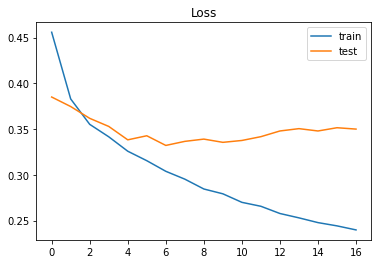

In [48]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

Our model begins overfitting around the 4th epoch, however since we are only saving the model with the best performance on the validation data it is safe to continue training. We see a small gain in performance even after teh model has overfit with our best model weights found in epoch 7. 

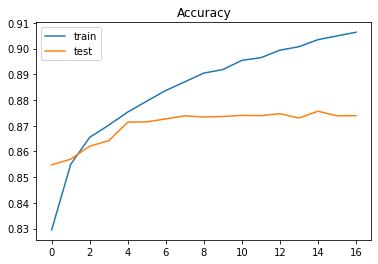

In [49]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

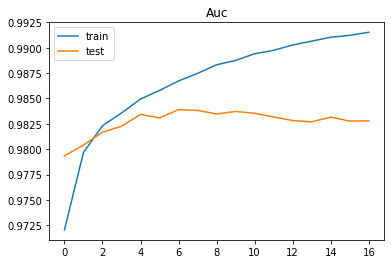

In [50]:
plt.title('Auc')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show();